In [1]:
using LinearAlgebra
using FFTW
using Random
using CairoMakie

<font size="12">Spinor Structure (finite S)</font>

In [2]:
function v_sigma(S, M, k, sigma)
    kx = k[1]
    ky = k[2]
    return sqrt(factorial(2*S) / factorial(S - sigma) / factorial(S + sigma)) * (kx - im*ky)^(S + sigma) * M^(S - sigma) / 
    (norm(k)^2 + M^2)^S
end

v_sigma (generic function with 1 method)

In [3]:
function spinor(S, M, k)
    vec = Array{ComplexF64}(undef, Int(2*S) + 1)
    for sigma in -S:S
        vec[Int(S + sigma) + 1] = v_sigma(S, M, k, sigma)
    end
    return vec
end

spinor (generic function with 1 method)

<font size="12">Form Factors</font>

In [4]:
a = 1 # lattice constant

1

In [5]:
G1 = [2*pi/a, -2*pi/(sqrt(3) * a)]
G2 = [0, 4*pi/(sqrt(3) * a)]
G3 = -G1 - G2

K1 = (2/3) * G1 + (1/3) * G2
K3 = K1 - G1
K5 = K1 + G3

K2 = (1/3) * G1 + (2/3) * G2
K4 = K2 + G3
K6 = K2 - G2

Kpts = [K1, K2, K3, K4, K5, K6]

6-element Vector{Vector{Float64}}:
 [4.1887902047863905, 0.0]
 [2.0943951023931953, 3.6275987284684357]
 [-2.0943951023931957, 3.6275987284684357]
 [-4.188790204786391, 0.0]
 [-2.0943951023931957, -3.6275987284684357]
 [2.0943951023931953, -3.6275987284684357]

In [6]:
# function Lambda(S, M, kappa_m, kappa_n)
#     return dot(spinor(S, M, kappa_m), spinor(S, M, kappa_n))
# end

In [7]:
function Lambda(B, k1, k2)
    kx1, ky1 = k1
    kx2, ky2 = k2
    cross = kx1*ky2 - ky1*kx2
    return exp(-B/4 * (norm(k1 - k2)^2 + 2im * cross))
end

Lambda (generic function with 1 method)

In [8]:
# Explicit form factor to check against spinor structure
function Lambda_v2(S, M, k1, k2)
    kx1, ky1 = k1
    kx2, ky2 = k2
    cross = kx1*ky2 - ky1*kx2
    return (M^2 + dot(k1, k2) - im*cross)^(2*S) / (M^2 + norm(k1)^2)^S / (M^2 + norm(k2)^2)^S
end

Lambda_v2 (generic function with 1 method)

<font size="12">Energy</font>

In [9]:
function E_hartree(B, C0, k_points)
    return (2/3) * real(exp(C0*(2*pi*im/3)) * Lambda(B, k_points[1], k_points[3]) * Lambda(B, k_points[4], k_points[6]))
end

E_hartree (generic function with 1 method)

In [10]:
function E_fock(B, C0, k_points)
    return (-2/3) * real(exp(C0*(-2*pi*im/3)) * Lambda(B, k_points[1], k_points[2]) * Lambda(B, k_points[4], k_points[5]))
end

E_fock (generic function with 1 method)

In [11]:
function E_tot(B, C0, k_points, Vg1, Vk1)
    return Vg1 * E_hartree(B, C0, k_points) + Vk1 * E_fock(B, C0, k_points)
end

E_tot (generic function with 1 method)

In [12]:
Vg = 1/sqrt(3)
Vk = 1
# S = 15.5
# m = 1

1

In [13]:
samps = 10^6
B_list = range(0, 1, samps)

0.0:1.000001000001e-6:1.0

In [14]:
# energies (C0, samples)
energies = Array{Float64}(undef, 3, samps)
for c in 0:2
    for k in 1:samps
        B = B_list[k]
        # energies[c + 1, k] = E_tot(B, c, Kpts, Vg, Vk)
        energies[c + 1, k] = E_fock(B, c, Kpts)
    end
end

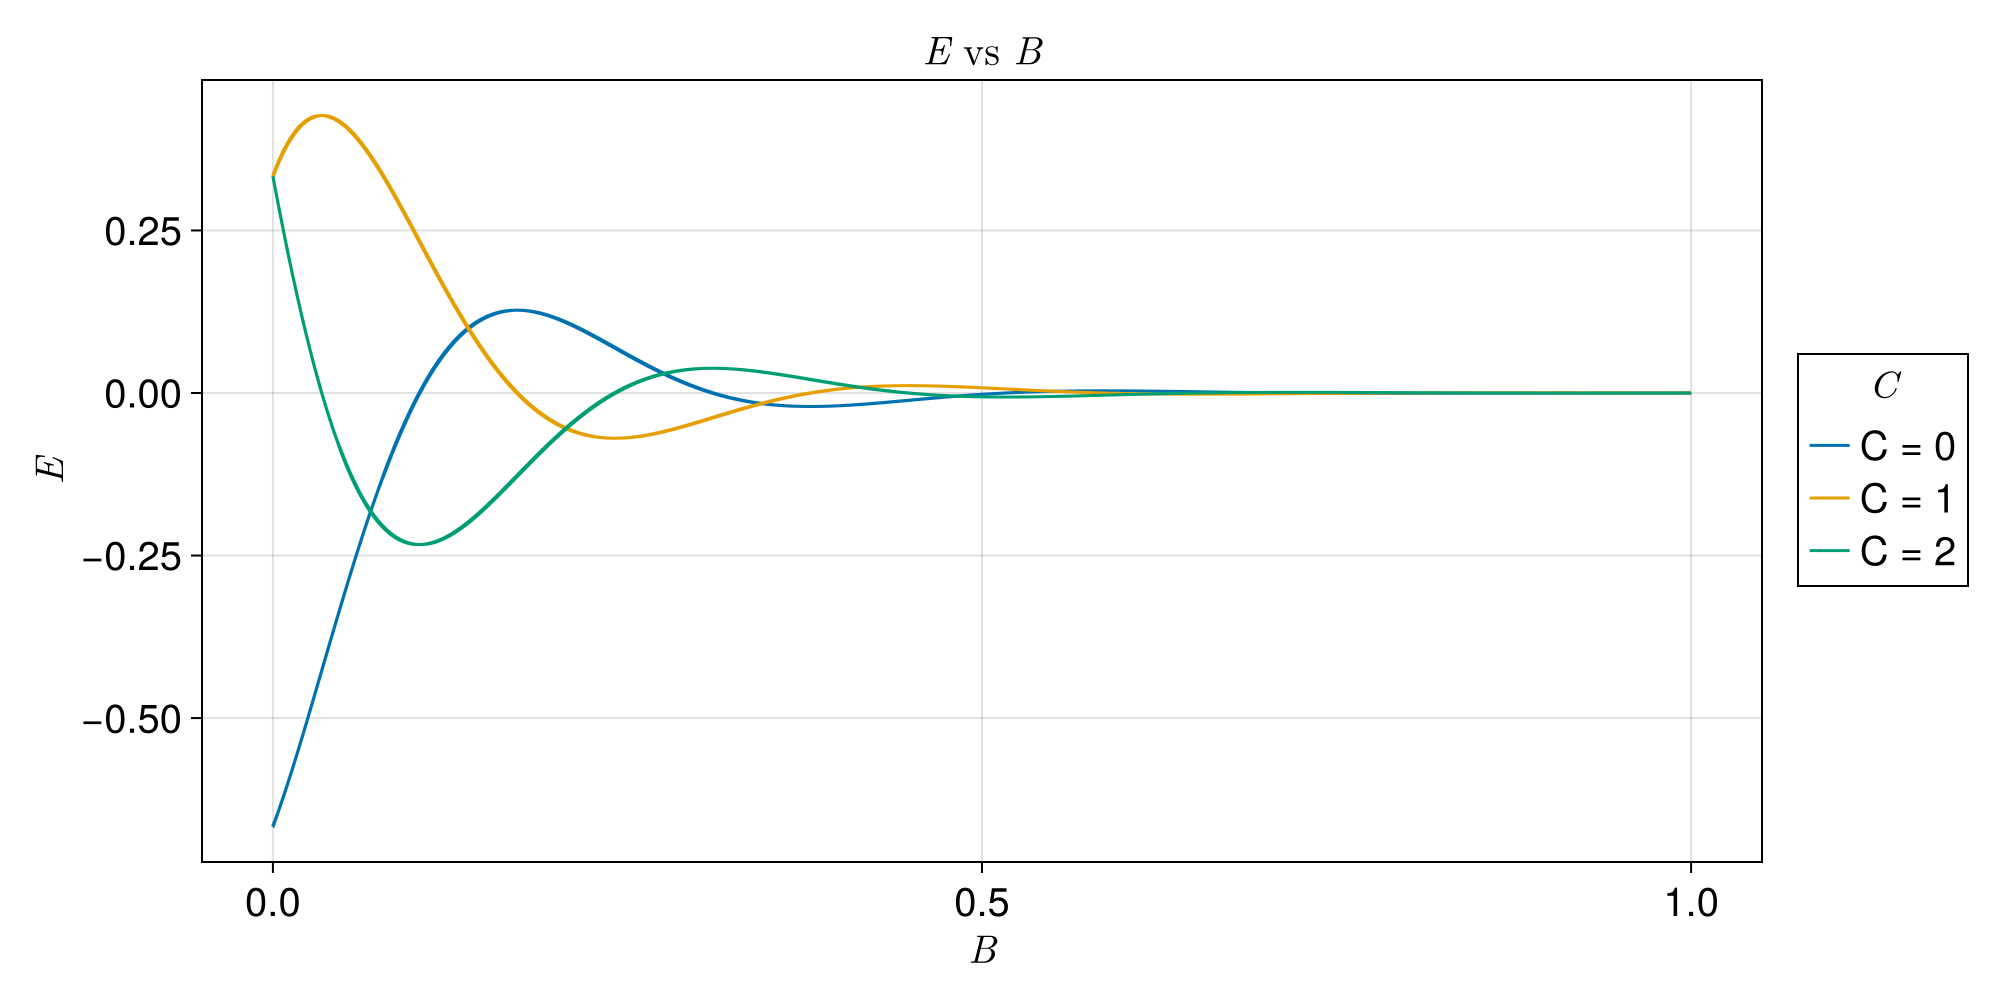

In [15]:
P = Figure(size=(1000, 500), fontsize=20)
ax = Axis(P[1, 1], 
title = L"E \ \text{vs} \ B", 
xlabel = L"B", ylabel = L"E")
for i in 1:3
    lines!(ax, B_list, energies[i, :], 
    label = "C = "*string(mod(i - 1, 3)))
end
P[1, 2] = Legend(P, ax, L"C", 
framevisible = true)
P

In [16]:
delta_energies = Array{Float64}(undef, 3, samps)
for k in 1:samps
    delta_energies[1, k] = energies[1, k] - min(energies[2, k], energies[3, k])
    delta_energies[2, k] = energies[2, k] - min(energies[3, k], energies[1, k])
    delta_energies[3, k] = energies[3, k] - min(energies[1, k], energies[2, k])
end

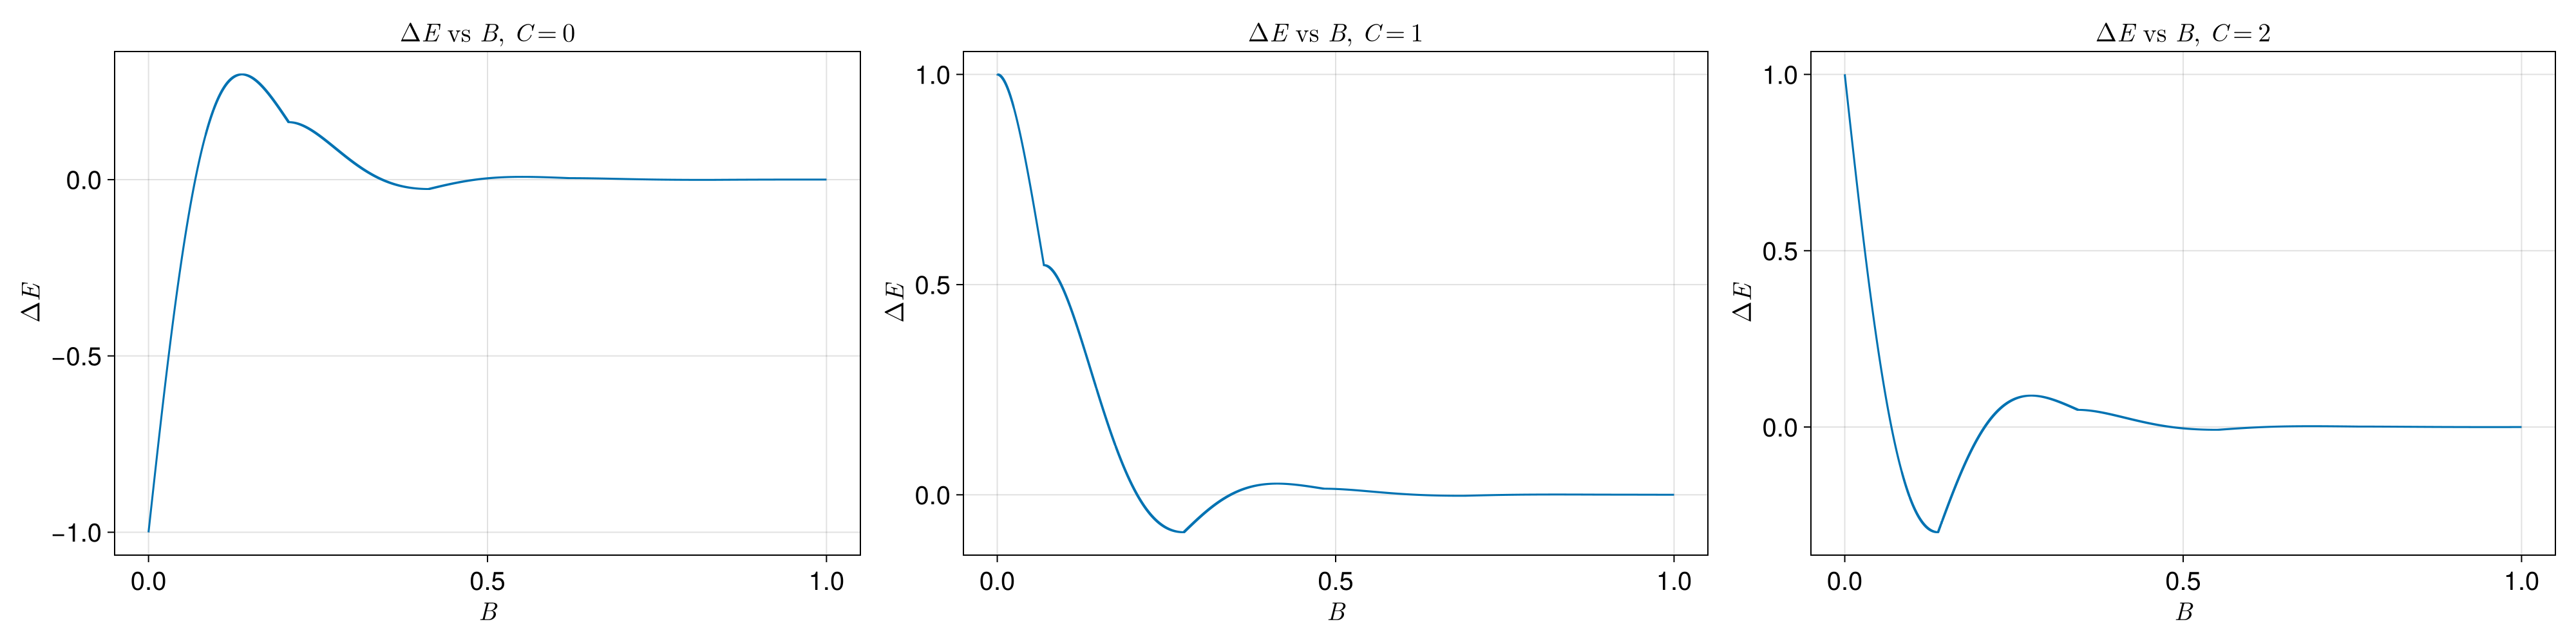

In [17]:
P = Figure(size=(2000, 500), fontsize=20)
a1x = Axis(P[1, 1], 
title = L"\Delta E \ \text{vs} \ B, \ C=0", 
xlabel = L"B", ylabel = L"\Delta E")
lines!(a1x, B_list, delta_energies[1, :])

a2x = Axis(P[1, 2], 
title = L"\Delta E \ \text{vs} \ B, \ C=1", 
xlabel = L"B", ylabel = L"\Delta E")
lines!(a2x, B_list, delta_energies[2, :])

a3x = Axis(P[1, 3], 
title = L"\Delta E \ \text{vs} \ B, \ C=2", 
xlabel = L"B", ylabel = L"\Delta E")
lines!(a3x, B_list, delta_energies[3, :])

P

In [18]:
crossing_B = Vector{Float64}()
crossing_E = Vector{Float64}()
for j in 1:samps - 1
    for i in 1:3
        if (delta_energies[i, j] < 0 && delta_energies[i, j + 1] > 0) || (delta_energies[i, j] > 0 && delta_energies[i, j + 1] < 0)
            append!(crossing_B, B_list[j])
            append!(crossing_E, energies[i, j])
            @show B_list[j]
            break
        end
    end
end

B_list[j] = 0.06891606891606891
B_list[j] = 0.20674820674820674
B_list[j] = 0.3445803445803446
B_list[j] = 0.4824124824124824
B_list[j] = 0.6202446202446202
B_list[j] = 0.7580767580767581
B_list[j] = 0.8959088959088959


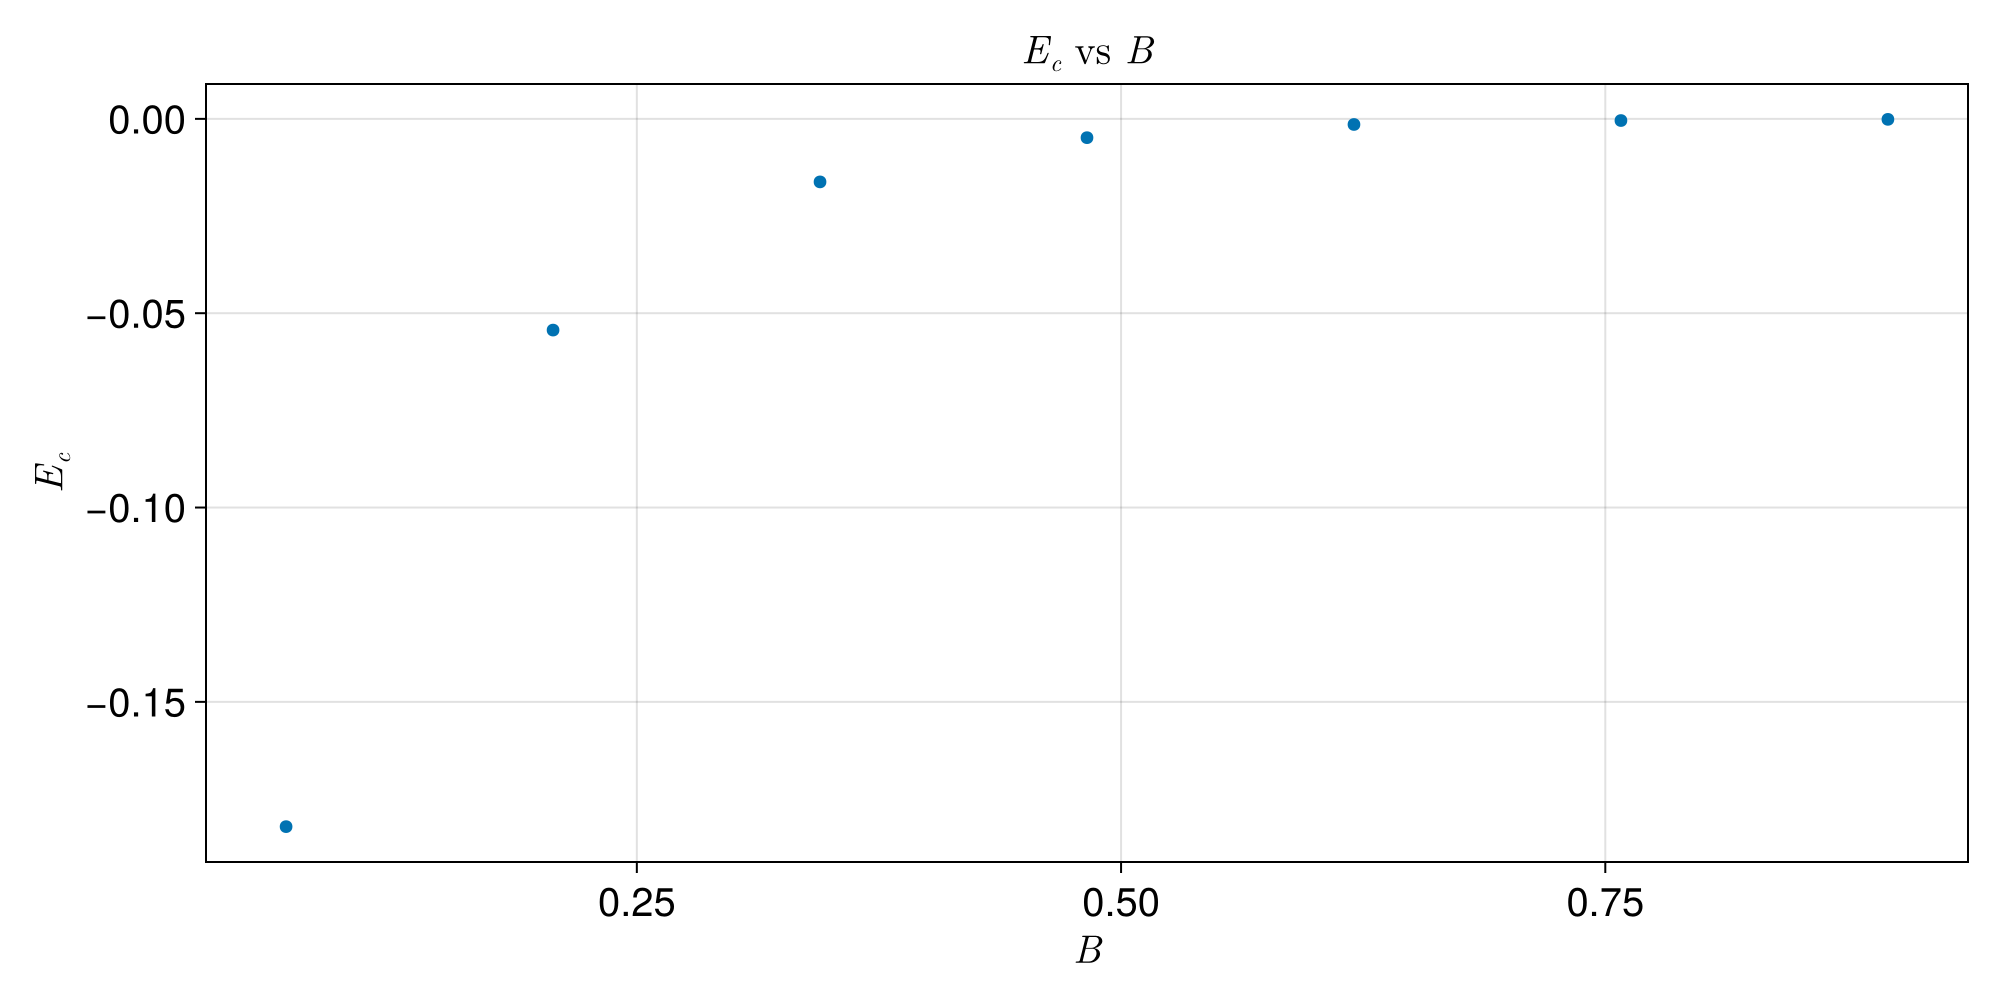

In [19]:
P = Figure(size=(1000, 500), fontsize=20)
ax = Axis(P[1, 1], 
title = L"E_c \ \text{vs} \ B", 
xlabel = L"B", ylabel = L"E_c")
scatter!(ax, crossing_B, crossing_E)
P

In [20]:
# honeycomb BZ area
area = 8 * pi^2 / (a^2 * sqrt(3))
crossing_numbers = crossing_B * area / (2 * pi)

7-element Vector{Float64}:
 0.4999996879419494
 1.499999063825848
 2.499998439709747
 3.499997815593646
 4.4999971914775445
 5.499996567361444
 6.4999959432453425

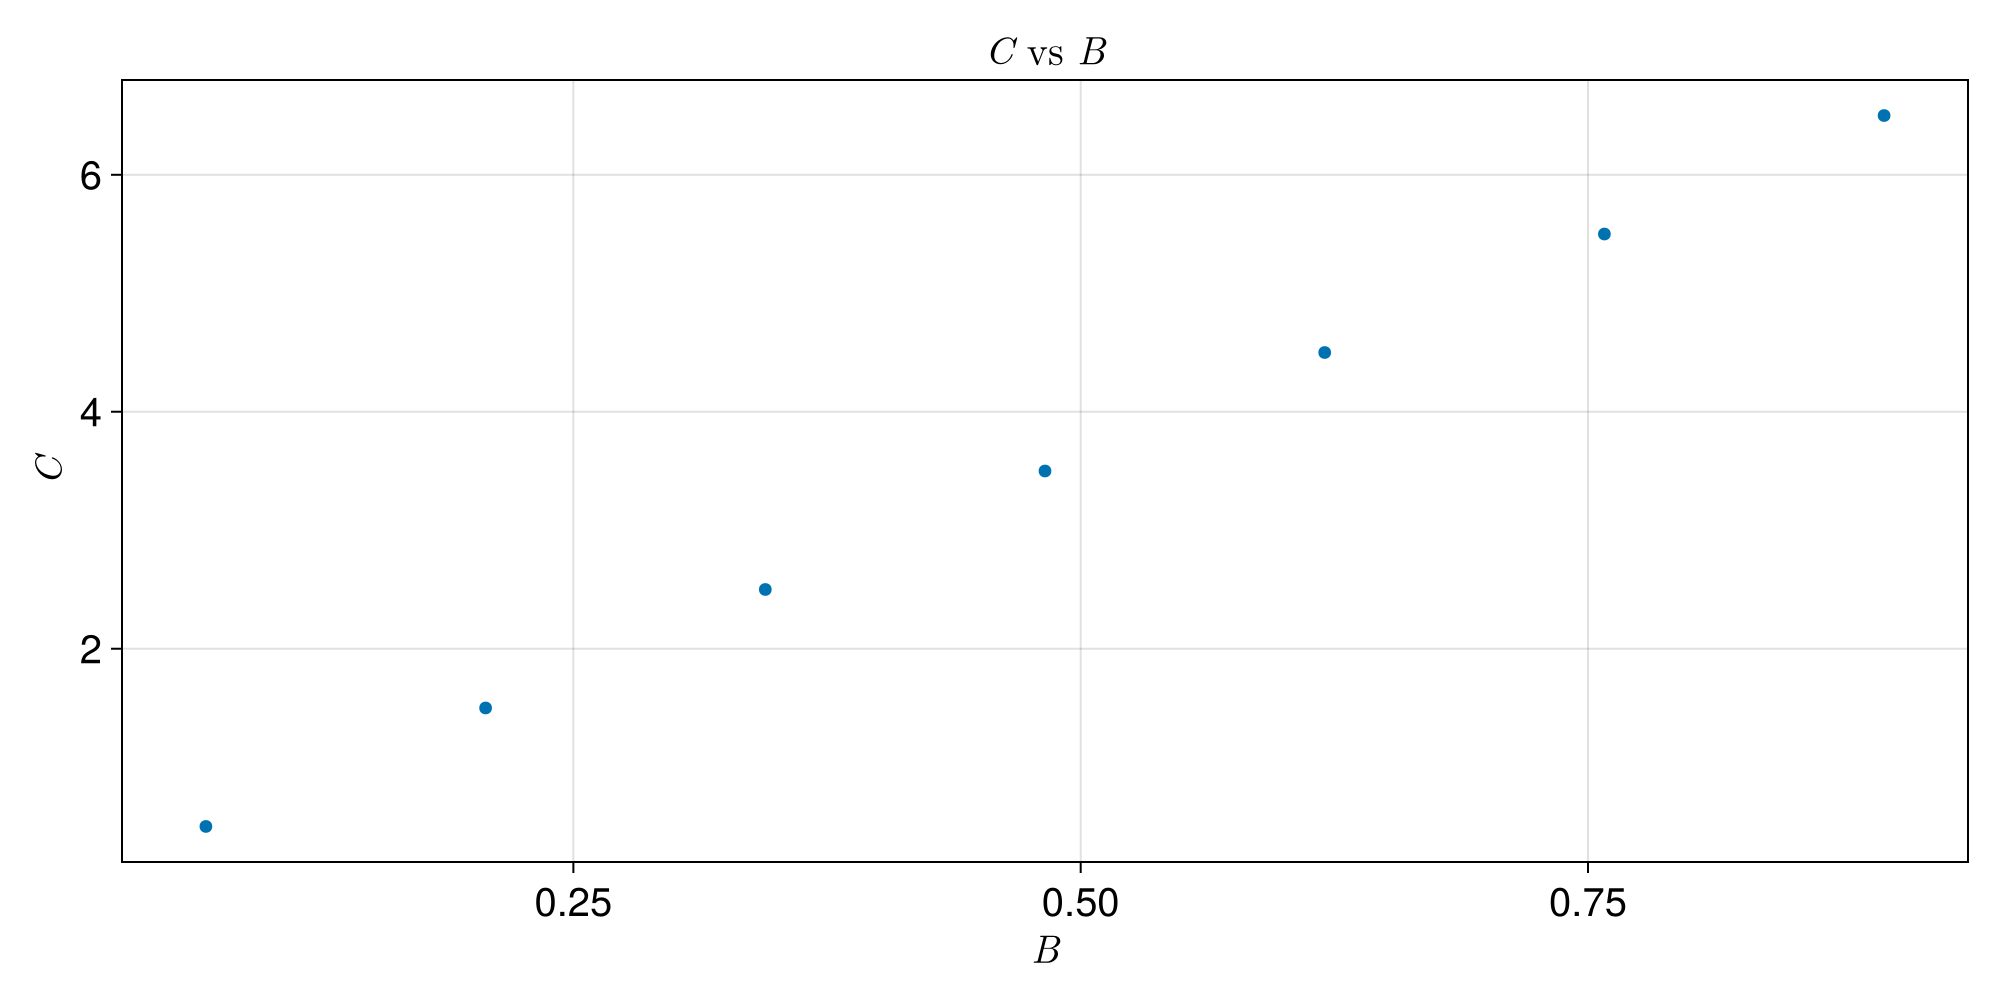

In [21]:
P = Figure(size=(1000, 500), fontsize=20)
ax = Axis(P[1, 1], 
title = L"C \ \text{vs} \ B", 
xlabel = L"B", ylabel = L"C")
scatter!(ax, crossing_B, crossing_numbers)
P

<font size="12">Berry Curvature</font>

In [22]:
# compute the phase difference between wavefunction at (x1, y1) and (x2, y2)
function theta(S, M, x1, y1, x2, y2)
    ev1 = spinor(S, M, [x1, y1])
    ev2 = spinor(S, M, [x2, y2])
    return dot(ev2, ev1) / abs(dot(ev2, ev1))
end

theta (generic function with 1 method)

In [23]:
# Berry flux through a plaquette with corners (x1, y1), (x2, y2), (x3, y3), (x4, y4)
function flux(S, M, x1, y1, x2, y2, x3, y3, x4, y4)
    big_theta = theta(S, M, x2, y2, x1, y1) *
        theta(S, M, x3, y3, x2, y2) * theta(S, M, x4, y4, x3, y3) * 
    theta(S, M, x1, y1, x4, y4)
    # Numerical instability around flux = pi, so we always force it to choose +pi
    if abs(imag(big_theta)) < 10^(-12)
        return abs(angle(big_theta))
    else
        return angle(big_theta)
    end
end

flux (generic function with 1 method)

In [24]:
# Berry curvature
function berry_curvature(points, n, S, M)
    berry_list = Vector{Float64}()
    avg_k_x = Vector{Float64}()
    avg_k_y = Vector{Float64}()
    for i in 1:(n - 1)
        for j in 1:(n - 1)
            x1 = points[i, j, 1]
            y1 = points[i, j, 2]
            
            x2 = points[i + 1, j, 1]
            y2 = points[i + 1, j, 2]
            
            x3 = points[i + 1, j + 1, 1]
            y3 = points[i + 1, j + 1, 2]
            
            x4 = points[i, j + 1, 1]
            y4 = points[i, j + 1, 2]
            
            x_avg = (x1 + x2 + x3 + x4)/4
            y_avg = (y1 + y2 + y3 + y4)/4
            
            append!(avg_k_x, x_avg)
            append!(avg_k_y, y_avg)
            curvature = flux(S, M, x1, y1, x2, y2, x3, y3, x4, y4)
            append!(berry_list, curvature)
        end
    end
    return berry_list, avg_k_x, avg_k_y
end

berry_curvature (generic function with 1 method)

In [25]:
function berry_curvature_v2(S, M, k)
    return (4 * S * M^2)/(norm(k)^2 + M^2)^2
end

berry_curvature_v2 (generic function with 1 method)

In [26]:
# This generates a line of points in K-space
function gen_list(xlim, n, shift, y)
    x_vals = range(-xlim + shift, shift, n)
    line_vals = Array{Float64}(undef, n, 2)
    for i in 1:n
        line_vals[i, :] = [x_vals[i], y]
    end
    return line_vals
end
# This generates a single unit cell of points in K-space
function gen_grid(xlim, n)
    step = range(0, xlim, n)
    grid = Array{Float64}(undef, n, n, 2)
    for i in 1:n
        grid[:, i, :] = gen_list(xlim, n, 0.5*step[i], (sqrt(3)/2)*step[i])
    end
    return grid
end
# Shift a grid over
function shift_grid(grid, n, xshift, yshift)
    new_grid = copy(grid)
    for i in 1:n
        new_grid[:, i, 2] += yshift * ones(size(grid[:, i, 2]))
        new_grid[:, i, 1] += xshift * ones(size(grid[:, i, 1]))
    end
    return new_grid
end

# This generates a line of points in K-space
function make_line(x0, x1, n, y)
    x_vals = range(x0, x1, n)
    line_vals = Array{Float64}(undef, n, 2)
    for i in 1:n
        line_vals[i, :] = [x_vals[i], y]
    end
    return line_vals
end

# draw a square around k of dimensions radius x radius (with point-density n)
function k_zone(k, n, radius)
    kx = k[1]
    ky = k[2]
    grid = Array{Float64}(undef, n, n, 2)
    ky_pts = range(ky - radius/2, ky + radius/2, n)
    for i in 1:n
        grid[:, i, :] = make_line(kx - radius/2, kx + radius/2, n, ky_pts[i])
    end
    return grid
end

k_zone (generic function with 1 method)

In [27]:
pd = 60
# BZ
uc_xlim = 4*pi/a
uc_ylim = uc_xlim * sqrt(3) / 2
k_BZ = gen_grid(uc_xlim, pd)

60×60×2 Array{Float64, 3}:
[:, :, 1] =
 -12.5664       -12.4599    -12.3534      …  -6.49617  -6.38968  -6.28319
 -12.3534       -12.2469    -12.1404         -6.28319  -6.17669  -6.0702
 -12.1404       -12.0339    -11.9274         -6.0702   -5.9637   -5.85721
 -11.9274       -11.8209    -11.7144         -5.85721  -5.75071  -5.64422
 -11.7144       -11.6079    -11.5014         -5.64422  -5.53772  -5.43123
 -11.5014       -11.3949    -11.2884      …  -5.43123  -5.32473  -5.21824
 -11.2884       -11.1819    -11.0754         -5.21824  -5.11174  -5.00525
 -11.0754       -10.969     -10.8625         -5.00525  -4.89875  -4.79226
 -10.8625       -10.756     -10.6495         -4.79226  -4.68577  -4.57927
 -10.6495       -10.543     -10.4365         -4.57927  -4.47278  -4.36628
 -10.4365       -10.33      -10.2235      …  -4.36628  -4.25979  -4.15329
 -10.2235       -10.117     -10.0105         -4.15329  -4.0468   -3.9403
 -10.0105        -9.904      -9.79751        -3.9403   -3.83381  -3.72731
 

In [28]:
tot_flux = B_list * area

0.0:4.55857956479081e-5:45.58575006211245

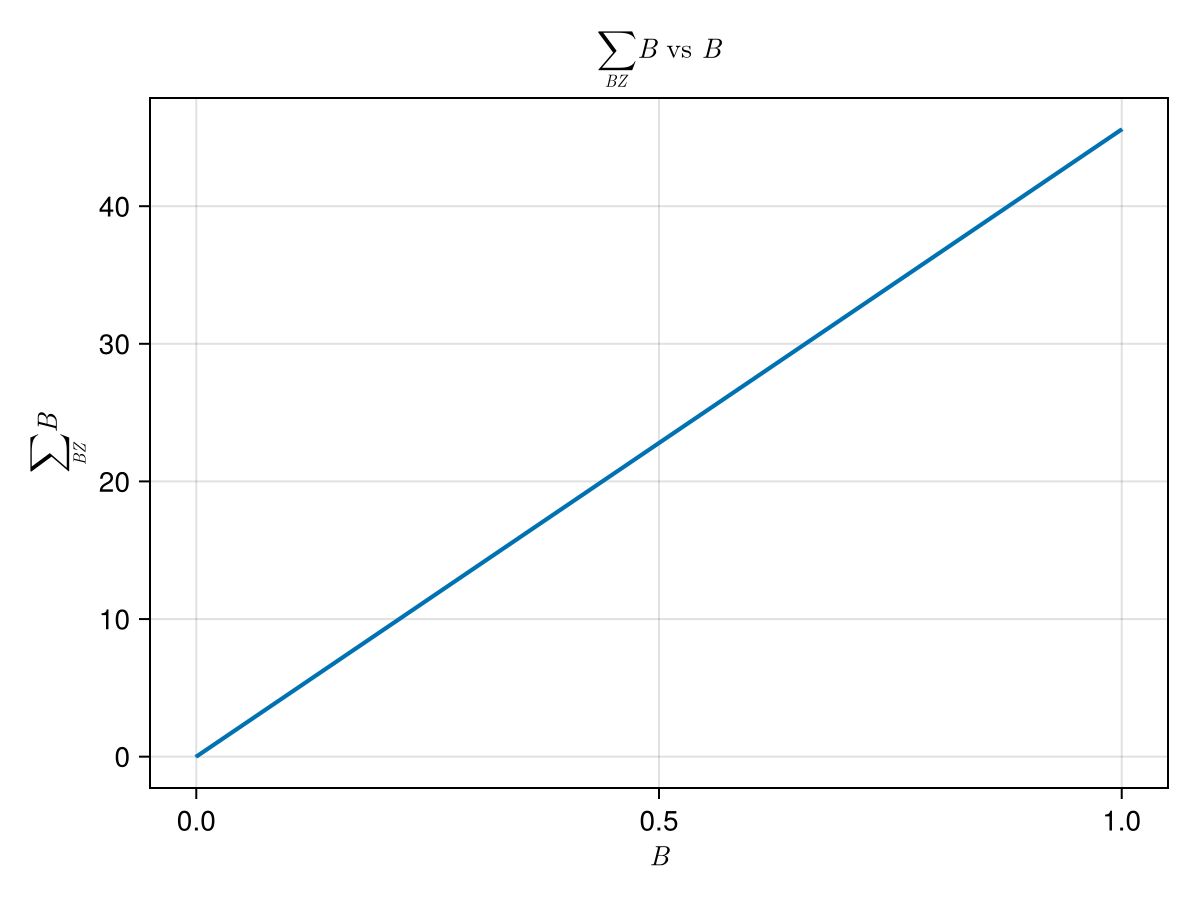

In [29]:
P = Figure()
ax = Axis(P[1, 1], 
title = L"\sum_{BZ} B \ \text{vs} \ B", 
xlabel = L"B", ylabel = L"\sum_{BZ} B")
lines!(ax, B_list, tot_flux)
P